In [1]:
import tensorflow as tf
import cv2

In [22]:
train_img = []
train_mask = []

val_img = []
val_mask =[]

test_img =[]
test_mask = []

for i in range(1,2500):
    train_img.append('/content/drive/MyDrive/brain tumer/images/' + f'{str(i)}.png')
    train_mask.append('/content/drive/MyDrive/brain tumer/masks/' + f'{str(i)}.png' )

for i in range(2500,2750):
    val_img.append( '/content/drive/MyDrive/brain tumer/images/' + f'{str(i)}.png')
    val_mask.append('/content/drive/MyDrive/brain tumer/masks/' + f'{str(i)}.png' )

for i in range(2750,3001):
    test_img.append( '/content/drive/MyDrive/brain tumer/images/' + f'{str(i)}.png')
    test_mask.append('/content/drive/MyDrive/brain tumer/masks/' + f'{str(i)}.png' )



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model = tf.keras.applications.MobileNetV2(input_shape= (128,128 ,3 ), include_top= False, weights = 'imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
def dataset(img_paths, mask_paths, img_size = (128, 128)):
    def processing(img_path, mask_path, img_size=(128,128)):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels= 3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels= 1)
        mask = tf.image.resize(mask, img_size)
        mask = tf.cast(mask, tf.int32)

        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(processing, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

trainset = dataset(train_img, train_mask, img_size=(128,128))
trainset = trainset.batch(32).prefetch(tf.data.AUTOTUNE)

valset = dataset(val_img, val_mask, img_size=(128,128))
valset = valset.batch(32).prefetch(tf.data.AUTOTUNE)

testset = dataset(test_img, test_mask, img_size = (128, 128))
testset = testset.batch(32).prefetch(tf.data.AUTOTUNE)

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Activation
from tensorflow.keras.models import Model

# Define the number of classes. Assuming binary segmentation (e.g., background and tumor).
# If your masks have more distinct values, adjust this.
num_classes = 2

# Define the input layer
input_tensor = tf.keras.Input(shape=(128, 128, 3))

# Use MobileNetV2 as the encoder (feature extractor)
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Connect the input to the base model
x = base_model(input_tensor) # Output shape will be (None, 4, 4, 1280) for 128x128 input

# Build a simple decoder to upsample the features to the original image size
# Upsample from 4x4 to 128x128
x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x) # Output: 8x8
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x) # Output: 16x16
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x) # Output: 32x32
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x) # Output: 64x64
x = Activation('relu')(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x) # Output: 128x128
x = Activation('relu')(x)

# Final convolutional layer for pixel-wise classification
# It should have `num_classes` filters and a 'softmax' activation for sparse_categorical_crossentropy
output_tensor = Conv2D(num_classes, (1, 1), activation='softmax')(x)

# Create the full segmentation model
model = Model(inputs=input_tensor, outputs=output_tensor)


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'bestmodel.h5',
        save_best_only= True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience = 10,
        restore_best_weights = True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor = 0.1,
        patience = 5
    )
]

model.compile(optimizer= tf.keras.optimizers.Adam(),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(trainset, epochs= 50, callbacks= callbacks)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9671 - loss: 0.1649

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


79/79 ━━━━━━━━━━━━━━━━━━━━ 495s 6s/step - accuracy: 0.9672 - loss: 0.1640 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0501

79/79 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step - accuracy: 0.9835 - loss: 0.0501 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0425

79/79 ━━━━━━━━━━━━━━━━━━━━ 408s 5s/step - accuracy: 0.9835 - loss: 0.0425 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0402

79/79 ━━━━━━━━━━━━━━━━━━━━ 400s 5s/step - accuracy: 0.9835 - loss: 0.0402 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0359

79/79 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.9835 - loss: 0.0359 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0320

79/79 ━━━━━━━━━━━━━━━━━━━━ 400s 5s/step - accuracy: 0.9835 - loss: 0.0320 - learning_rate: 0.0010
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0292

79/79 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.9835 - loss: 0.0292 - learning_rate: 0.0010
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0289

79/79 ━━━━━━━━━━━━━━━━━━━━ 407s 5s/step - accuracy: 0.9835 - loss: 0.0289 - learning_rate: 0.0010
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9871 - loss: 0.0271

79/79 ━━━━━━━━━━━━━━━━━━━━ 408s 5s/step - accuracy: 0.9871 - loss: 0.0271 - learning_rate: 0.0010
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9885 - loss: 0.0263

79/79 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - accuracy: 0.9885 - loss: 0.0263 - learning_rate: 0.0010


In [25]:
def dataset(img_paths, mask_paths, img_size = (128, 128)):
    def processing(img_path, mask_path, img_size=(128,128)):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels= 3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels= 1)
        mask = tf.image.resize(mask, img_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.cast(mask, tf.int32)
        # Remap mask values: assuming 255 is foreground, remap to 1
        mask = tf.where(mask == 255, 1, mask)

        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(processing, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

trainset = dataset(train_img, train_mask, img_size=(128,128))
trainset = trainset.batch(32).prefetch(tf.data.AUTOTUNE)

valset = dataset(val_img, val_mask, img_size=(128,128))
valset = valset.batch(32).prefetch(tf.data.AUTOTUNE)

testset = dataset(test_img, test_mask, img_size = (128, 128))
testset = testset.batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
def predict (model, img_path, img_size=(128,128)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3) # Corrected: pass 'img' (content) instead of 'img_path'
    org_size = tf.shape(img)[:2]

    img = tf.image.resize(img , img_size)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis = 0)

    pred = model.predict(img)
    pred = tf.argmax(pred, axis = -1 )

    pred = tf.image.resize(
        tf.expand_dims(pred, axis = -1),
        org_size,
        method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    return tf.squeeze(pred).numpy()

In [19]:
def visualize(img, mask, pred):
    fig, axes = plt.subplots(1,3, figsize= (15,5))

    axes[0].imshow(img)
    axes[0].set_title('original')

    axes[1].imshow(mask)
    axes[1].set_title('ground truth')

    axes[2].imshow(pred)
    axes[2].set_title('prediction')


    plt.show()

In [26]:
model.predict(testset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step


array([[[[0.5000145 , 0.49998555],
         [0.5000062 , 0.49999377],
         [0.49982446, 0.5001754 ],
         ...,
         [0.50013494, 0.49986497],
         [0.50015455, 0.4998454 ],
         [0.50005245, 0.49994758]],

        [[0.5000762 , 0.49992383],
         [0.50011367, 0.49988633],
         [0.4999988 , 0.50000125],
         ...,
         [0.50036395, 0.49963596],
         [0.50033265, 0.4996674 ],
         [0.5000501 , 0.4999499 ]],

        [[0.4998787 , 0.5001213 ],
         [0.49991292, 0.500087  ],
         [0.50014746, 0.49985242],
         ...,
         [0.49994564, 0.5000544 ],
         [0.50006914, 0.49993083],
         [0.5000195 , 0.4999805 ]],

        ...,

        [[0.5002718 , 0.49972817],
         [0.5005898 , 0.49941024],
         [0.5001934 , 0.4998066 ],
         ...,
         [0.5032543 , 0.49674568],
         [0.5032597 , 0.49674025],
         [0.502434  , 0.49756593]],

        [[0.5011934 , 0.49880657],
         [0.49942005, 0.5005799 ],
         [0.

60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


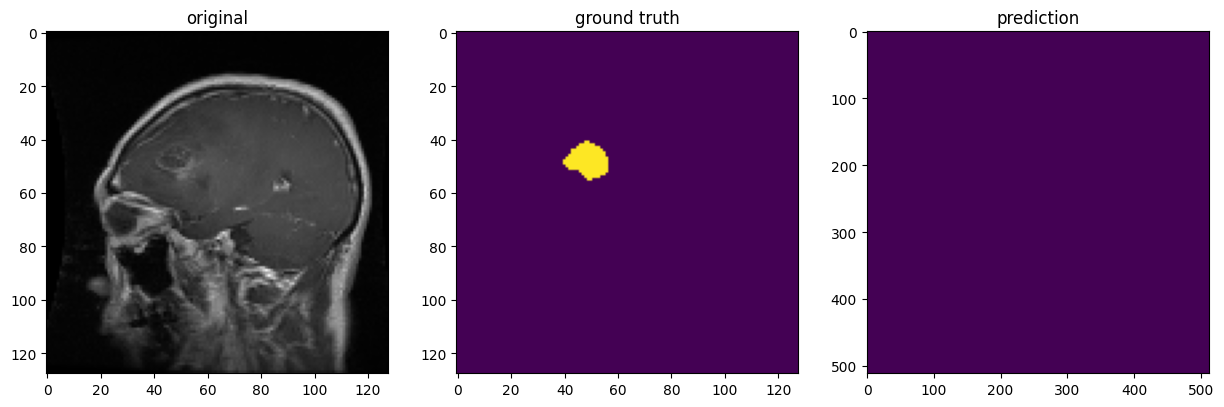

In [47]:
import matplotlib.pyplot as plt
import numpy as np
#x = np.random.seed(42)
x = np.random.randint(100)
print(x)
sample_img_path = test_img[x]
sample_mask_path = test_mask[x]

# Get the original image for visualization
original_img = tf.io.read_file(sample_img_path)
original_img = tf.image.decode_png(original_img, channels=3)
original_img = tf.image.resize(original_img, (128,128))
original_img = tf.cast(original_img, tf.float32) / 255.0

# Get the original mask for visualization (with remapping for display)
ground_truth_mask = tf.io.read_file(sample_mask_path)
ground_truth_mask = tf.image.decode_png(ground_truth_mask, channels=1)
ground_truth_mask = tf.image.resize(ground_truth_mask, (128,128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
ground_truth_mask = tf.where(ground_truth_mask == 255, 1, ground_truth_mask)
ground_truth_mask = tf.squeeze(ground_truth_mask).numpy()


# Predict the mask using the defined predict function
predicted_mask = predict(model, sample_img_path)

# Visualize the results
visualize(original_img.numpy(), ground_truth_mask, predicted_mask)